In [61]:
import pandas as pd

log_file=pd.read_csv('samtools_performance_log.csv',header=None)

### Missing data adjustment

In [62]:
pd.set_option('display.max_rows', 100)
log_file

,0,1,2,3,4
0,consensus,chr3R-17815,2022-09-24 15:43:44.262445180,2022-09-24 15:43:44.274562837,1
1,consensus,chr3R-17815,2022-09-24 15:43:44.276863717,2022-09-24 15:43:44.288979421,2
2,consensus,chr3R-17815,2022-09-24 15:43:44.291243654,2022-09-24 15:43:44.303207729,3
3,consensus,chr3R-17815,2022-09-24 15:43:44.305221650,2022-09-24 15:43:44.316662409,4
4,consensus,chr3R-17815,2022-09-24 15:43:44.318612401,2022-09-24 15:43:44.330906590,5
...,...,...,...,...,...
2695,mpileup,chr3R-534450,2022-09-24 15:45:32.998834582,2022-09-24 15:45:33.046254724,26
2696,mpileup,chr3R-534450,2022-09-24 15:45:33.048436201,2022-09-24 15:45:33.094149466,27
2697,mpileup,chr3R-534450,2022-09-24 15:45:33.096307811,2022-09-24 15:45:33.144338919,28
2698,mpileup,chr3R-534450,2022-09-24 15:45:33.146547162,2022-09-24 15:45:33.193089188,29


In [63]:
log_file.rename(columns={0: 'function_name',
                   1: 'data_range',
                   2: 'start_datetime',
                   3: 'end_datetime',
                   4: 'iteration'},inplace=True)

In [64]:
import datetime

diff=[]
for idx in log_file.index:
    time_diff=datetime.datetime.strptime(log_file.loc[idx,'end_datetime'][:-3],'%Y-%m-%d %H:%M:%S.%f')-datetime.datetime.strptime(log_file.loc[idx,'start_datetime'][:-3],'%Y-%m-%d %H:%M:%S.%f')
    diff.append(time_diff.total_seconds())

log_file['time_diff']=diff


### Graph datasets creation

In [65]:
log_file_consensus=log_file[log_file['function_name'].str.match('consensus')]
log_file_coverage=log_file[log_file['function_name'].str.match('coverage')]
log_file_mpileup=log_file[log_file['function_name'].str.match('mpileup')]

In [66]:
def produce_df_graph(log_file_df):

    df_graph=pd.DataFrame(columns=['bases_num','mean','mean_time','sd','sd_time','iter_count'])

    df_graph['mean']=log_file_df.groupby(['data_range'])['time_diff'].mean()
    df_graph['sd']=log_file_df.groupby(['data_range'])['time_diff'].std()
    df_graph['sd']=df_graph['sd'].fillna(0)
    df_graph['iter_count']=log_file_df.groupby(['data_range'])['time_diff'].count()

    df_graph=df_graph.reset_index()

    for row in df_graph.index:
        df_graph.loc[row,'mean_time']=str(datetime.timedelta(seconds=df_graph.loc[row,'mean']))
        df_graph.loc[row,'sd_time']=str(datetime.timedelta(seconds=df_graph.loc[row,'sd']))
        df_graph.loc[row,'bases_num']=int(df_graph.loc[row,'data_range'].rsplit("-")[-1])

    df_graph=df_graph.drop('data_range',axis=1)


    df_graph=df_graph.sort_values('bases_num', ascending=True)
    df_graph=df_graph.set_index('bases_num')

    return df_graph

### Graphs

In [67]:
consensus_graph=produce_df_graph(log_file_consensus)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [68]:
coverage_graph=produce_df_graph(log_file_coverage)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [69]:
mpileup_graph=produce_df_graph(log_file_mpileup)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [84]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams['figure.figsize'] = [10,5]
#plt.rcParams['figure.dpi'] = 150

def plot_graph(x,y,polyplot=True,grade=3):
    
    fig, ax = plt.subplots()
    
    ax.scatter( x ,y, marker=".", label='Data points')
    
    if polyplot==True:
        z = np.polyfit(x, y, grade)
        fit_equation = np.poly1d(z)
    
        X_fit = np.linspace(min(x), max(x), 1000)
        Y_fit = fit_equation(X_fit)
    
        ax.plot(X_fit, Y_fit, color='r', alpha=0.3, label='Polynomial fit')
    
    
    #base = "{}k"
    base = "{}"
    xlabels=[base.format(int(year)) for year in np.arange(0, max(x)/1000, 30)]
    
    ax.xaxis.set_ticks(np.arange(0, max(x), 30000),labels=xlabels)
    ax.yaxis.set_ticks(np.arange(0.01, max(y)+0.002, 0.002))
    
    ax.set_xticklabels(xlabels, rotation=45)
    
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.set_xlabel('bases range (x1000)',labelpad=20)
    ax.set_ylabel('seconds',labelpad=20)
    
    
    return plt.show()

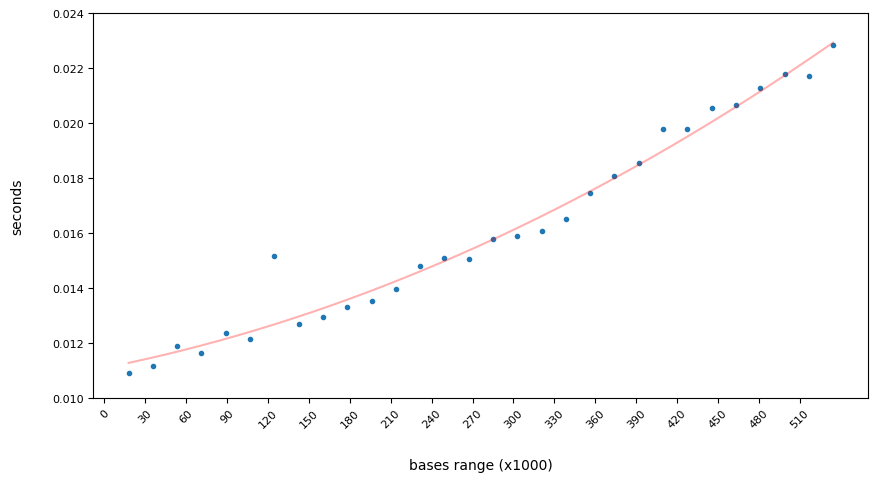

In [91]:
plot_graph(consensus_graph.index,consensus_graph['mean'],polyplot=True,grade=2)

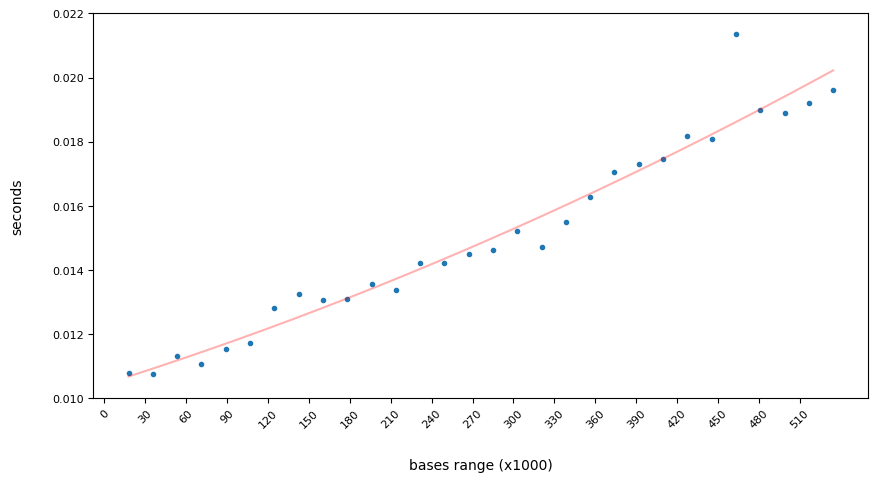

In [92]:
plot_graph(coverage_graph.index,coverage_graph['mean'],polyplot=True,grade=2)

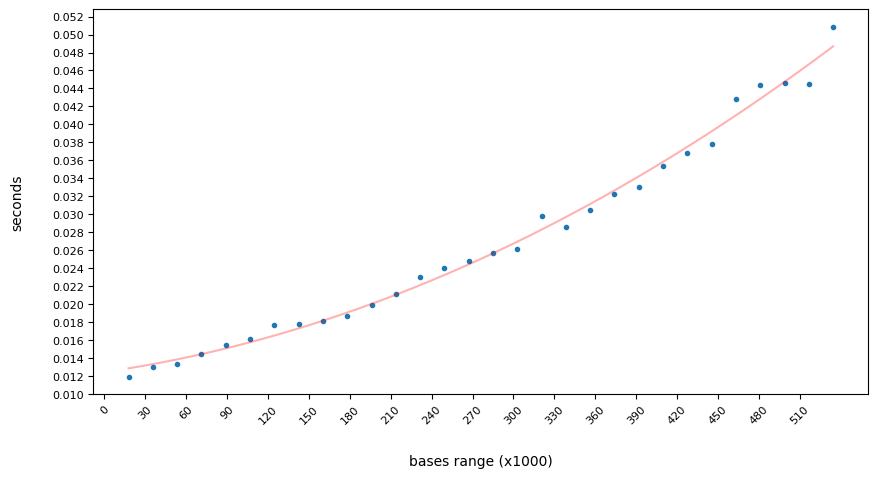

In [93]:
plot_graph(mpileup_graph.index,mpileup_graph['mean'],polyplot=True,grade=2)